<a href="https://colab.research.google.com/github/Edwin334/image_edit-/blob/main/sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Replicate API Token set.
✅ Using image: /content/test2.jpg
Using device: cuda


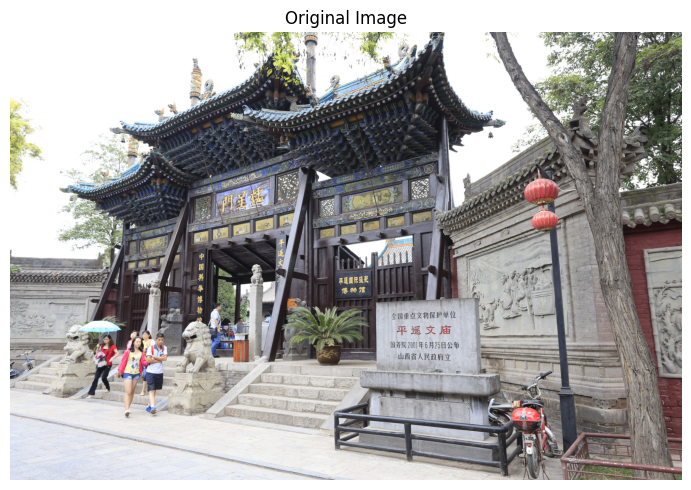

In [4]:
# @title 1. Setup: Install Dependencies, Define Helpers, Config

!pip install -q opencv-python-headless Pillow numpy replicate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q segment-anything transformers groundingdino-py huggingface_hub


import os
import numpy as np
import torch
import replicate
import cv2
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display, Markdown
import matplotlib.pyplot as plt


import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import predict as dino_predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry, SamPredictor


REPLICATE_API_TOKEN = "r8_Iiwz2ay8appJ6leHukWN5NpXFTssdfr0nRW5K"
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
print("✅ Replicate API Token set.")

IMAGE_PATH = "/content/test2.jpg"
if not os.path.exists(IMAGE_PATH):
     print(f"🛑 Image not found at {IMAGE_PATH}. Please upload the image.")
     IMAGE_PATH = None
else:
    print(f"✅ Using image: {IMAGE_PATH}")


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    """Loads GroundingDINO model from HuggingFace Hub"""
    try:
        cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
        args = SLConfig.fromfile(cache_config_file)
        model = build_model(args)
        args.device = device
        cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
        checkpoint = torch.load(cache_file, map_location='cpu')
        log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
        print(f"GroundingDINO Model loaded from {cache_file} \n => {log}")
        model = model.to(device)
        model.eval()
        return model
    except Exception as e:
        print(f"🛑 Error loading GroundingDINO model: {e}")
        raise

def transform_image(image: Image.Image) -> torch.Tensor:
    """Transforms PIL Image for GroundingDINO"""
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image_transformed, _ = transform(image, None)
    return image_transformed

SAM_MODELS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}
CACHE_PATH = os.environ.get("TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints"))


VALID_DIMENSIONS = [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024]
def find_largest_valid_dimension_lower_than(dimension):
    dimension = min(dimension, 1024)
    valid_dims = [d for d in VALID_DIMENSIONS if d <= dimension]
    if not valid_dims: return min(VALID_DIMENSIONS)
    return max(valid_dims)

# Display helper
def display_images(images, titles, figsize=(15, 5)):
    if not isinstance(images, list): images = [images]
    if not isinstance(titles, list): titles = [titles]
    plt.figure(figsize=figsize)
    for i, (img_data, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        img = None
        if isinstance(img_data, str) and os.path.exists(img_data):
            try: img = Image.open(img_data).convert("RGB")
            except Exception as e: print(f"Error loading image {img_data}: {e}")
        elif isinstance(img_data, Image.Image): img = img_data.convert("RGB")
        elif isinstance(img_data, np.ndarray): img = Image.fromarray(img_data)
        if img: plt.imshow(img)
        else: plt.text(0.5, 0.5, f'Invalid Image\n{title}', ha='center', va='center')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualization helper (adapted from previous)
# In Cell 1 (@title 1. Setup...) replace the old draw_output with this:

def draw_output(image, masks=None, boxes=None, phrases=None, alpha=0.5):
    """Draw masks and/or boxes with phrases on image."""
    if isinstance(image, Image.Image): image = np.array(image.convert("RGB"))
    vis_image = image.copy()
    vis_image_bgr = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)

    if masks is not None and isinstance(masks, torch.Tensor) and masks.numel() > 0:
        color_mask = np.array([255, 0, 0], dtype=np.uint8) # Blue mask (BGR)
        combined_mask_np = np.zeros(masks[0].shape, dtype=bool)
        for i in range(masks.shape[0]):
            mask_np = masks[i].cpu().numpy().astype(bool)
            if mask_np.shape != (vis_image.shape[0], vis_image.shape[1]):
                print(f"Warning: Mask shape {mask_np.shape} mismatch with image {vis_image.shape[:2]}. Skipping mask draw.")
                continue
            combined_mask_np = np.logical_or(combined_mask_np, mask_np)

        vis_image_bgr[combined_mask_np] = vis_image_bgr[combined_mask_np] * (1-alpha) + color_mask * alpha
    elif masks is not None and isinstance(masks, np.ndarray) and masks.size > 0:
         if masks.shape == (vis_image.shape[0], vis_image.shape[1]) and masks.dtype == bool:
            color_mask = np.array([255, 0, 0], dtype=np.uint8) # Blue mask (BGR)
            vis_image_bgr[masks] = vis_image_bgr[masks] * (1-alpha) + color_mask * alpha
         else:
             print(f"Warning: Numpy mask shape {masks.shape} or dtype {masks.dtype} invalid. Skipping mask draw.")


    if boxes is not None and isinstance(boxes, torch.Tensor) and boxes.numel() > 0:
        num_boxes = boxes.shape[0]
        boxes_cpu = boxes.cpu()
        for i in range(num_boxes):
            box = boxes_cpu[i]
            box_coords = box.tolist(); x1, y1, x2, y2 = map(int, box_coords)
            cv2.rectangle(vis_image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
            if phrases is not None and i < len(phrases):
                label = f"{phrases[i]}"

                (w, h), _ = cv2.getTextSize(str(label), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(vis_image_bgr, (x1, y1 - 20), (x1 + w, y1), (0, 255, 0), -1)
                cv2.putText(vis_image_bgr, str(label), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    vis_image_rgb = cv2.cvtColor(vis_image_bgr, cv2.COLOR_BGR2RGB)
    return vis_image_rgb


def place_cropped_result_back(original_image_path, inpainted_image_path, mask_path, output_path, crop_box):
    print("--- Compositing Result ---")
    original=Image.open(original_image_path).convert('RGB'); inpainted=Image.open(inpainted_image_path).convert('RGB')
    full_mask=Image.open(mask_path).convert('L'); orig_width,orig_height=original.size; left,top,right,bottom=crop_box
    crop_width=right-left; crop_height=bottom-top
    inpainted_resized=inpainted.resize((crop_width,crop_height),Image.Resampling.LANCZOS)
    print(f"Resized inpainted result from {inpainted.size} back to {inpainted_resized.size}.")
    final_image=original.copy(); final_image.paste(inpainted_resized,(left,top)); original_arr=np.array(original)
    final_arr=np.array(final_image); mask_arr=np.array(full_mask); binary_mask=mask_arr > 128
    if binary_mask.shape != (orig_height,orig_width):
        print(f"Warning: Mask dim {binary_mask.shape} != image dim {(orig_height, orig_width)}. Resizing mask.")
        binary_mask = cv2.resize(mask_arr,(orig_width,orig_height),interpolation=cv2.INTER_NEAREST) > 128
    binary_mask_3d=np.stack([binary_mask]*3,axis=-1); composite_arr=np.where(binary_mask_3d,final_arr,original_arr)
    composite_image=Image.fromarray(composite_arr); composite_image.save(output_path)
    print(f"💾 Final composited image saved to {output_path}"); return output_path



display_images(IMAGE_PATH, "Original Image")

In [5]:
# @title 2. Initialize GroundingDINO and SAM Models


GDINO_REPO_ID = "ShilongLiu/GroundingDINO"
GDINO_FILENAME = "groundingdino_swinb_cogcoor.pth"
GDINO_CONFIG_FILENAME = "GroundingDINO_SwinB.cfg.py"


SAM_MODEL_TYPE = "vit_h"
SAM_CHECKPOINT_URL = SAM_MODELS[SAM_MODEL_TYPE]

grounding_dino_model = None
sam_predictor = None


print("⏳ Loading GroundingDINO model...")
grounding_dino_model = load_model_hf(GDINO_REPO_ID, GDINO_FILENAME, GDINO_CONFIG_FILENAME, device=DEVICE)
print("✅ GroundingDINO model loaded.")


print(f"⏳ Loading SAM model ({SAM_MODEL_TYPE})...")
sam = sam_model_registry[SAM_MODEL_TYPE]()
state_dict = torch.hub.load_state_dict_from_url(SAM_CHECKPOINT_URL, model_dir=CACHE_PATH)
sam.load_state_dict(state_dict, strict=True)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)
print("✅ SAM model and predictor loaded.")
models_loaded = True


⏳ Loading GroundingDINO model...
final text_encoder_type: bert-base-uncased
GroundingDINO Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
✅ GroundingDINO model loaded.
⏳ Loading SAM model (vit_h)...
✅ SAM model and predictor loaded.



🖼️ Loading image: /content/test2.jpg
🔍 Running GroundingDINO with prompt: 'plant'...


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

GroundingDINO found 3 potential objects.

⏳ Running SAM segmentation for 3 boxes...
✅ SAM generated 3 masks.

🎨 Visualizing Combined GroundingDINO + SAM Output...
💾 Combined visualization saved to /content/gdinio_sam_visualization.jpg


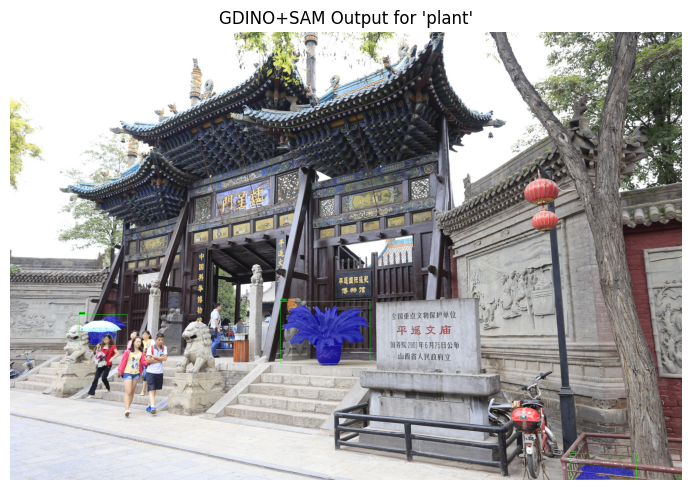

In [6]:
# @title 3. Run Prediction Pipeline (GroundingDINO + SAM) & Visualize SAM Output


TEXT_PROMPT = "plant"      # Object to detect
BOX_THRESHOLD = 0.3        # GroundingDINO confidence threshold for boxes
TEXT_THRESHOLD = 0.25      # GroundingDINO confidence threshold for text match

OUTPUT_VIZ_PATH = "/content/gdinio_sam_visualization.jpg"
OUTPUT_MASK_PATH = "/content/gdinio_sam_mask_full.png"


boxes = None
logits = None
phrases = None
masks = None
pipeline_success = False
image_pil = None

# --- Run Pipeline ---

print(f"\n🖼️ Loading image: {IMAGE_PATH}")
image_pil = Image.open(IMAGE_PATH).convert("RGB")
orig_width, orig_height = image_pil.size

# --- 1. GroundingDINO Prediction ---
print(f"🔍 Running GroundingDINO with prompt: '{TEXT_PROMPT}'...")
image_transformed = transform_image(image_pil)
dino_prompt = TEXT_PROMPT if TEXT_PROMPT.endswith('.') else TEXT_PROMPT + '.'

boxes_raw, logits, phrases = dino_predict(
    model=grounding_dino_model,
    image=image_transformed,
    caption=dino_prompt,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

print(f"GroundingDINO found {len(boxes_raw)} potential objects.")

if len(boxes_raw) > 0:
    processed_boxes_raw = box_ops.box_cxcywh_to_xyxy(boxes_raw)
    scaling_tensor = torch.tensor([orig_width, orig_height, orig_width, orig_height], device=DEVICE)
    boxes = processed_boxes_raw.to(DEVICE) * scaling_tensor # Move boxes_raw to DEVICE first

    # --- 2. SAM Prediction ---
    print(f"\n⏳ Running SAM segmentation for {len(boxes)} boxes...")
    image_np = np.array(image_pil)
    sam_predictor.set_image(image_np)
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes.to(DEVICE), image_np.shape[:2])

    masks_raw, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(sam_predictor.device),
        multimask_output=False,
    )
    masks = masks_raw.squeeze(1)
    print(f"✅ SAM generated {masks.shape[0]} masks.")
    pipeline_success = True

    print("\n🎨 Visualizing Combined GroundingDINO + SAM Output...")
    pipeline_vis_image = draw_output(image_pil, masks=masks, boxes=boxes, phrases=phrases)
    pipeline_vis_pil = Image.fromarray(pipeline_vis_image)
    pipeline_vis_pil.save(OUTPUT_VIZ_PATH)
    print(f"💾 Combined visualization saved to {OUTPUT_VIZ_PATH}")
    display_images(OUTPUT_VIZ_PATH, f"GDINO+SAM Output for '{TEXT_PROMPT}'")

else:
    pipeline_success = False



🎯 Selecting best detection...
Selected #0 (Phrase: 'plant', Score: 0.6993)
💾 Creating and saving full-size mask...
Full mask saved to /content/gdinio_sam_mask_full.png

✂️ Cropping image and mask around best detection...
Cropped to 1024x1024 at (2055, 1934, 3079, 2958)
💾 Cropped image and mask saved.


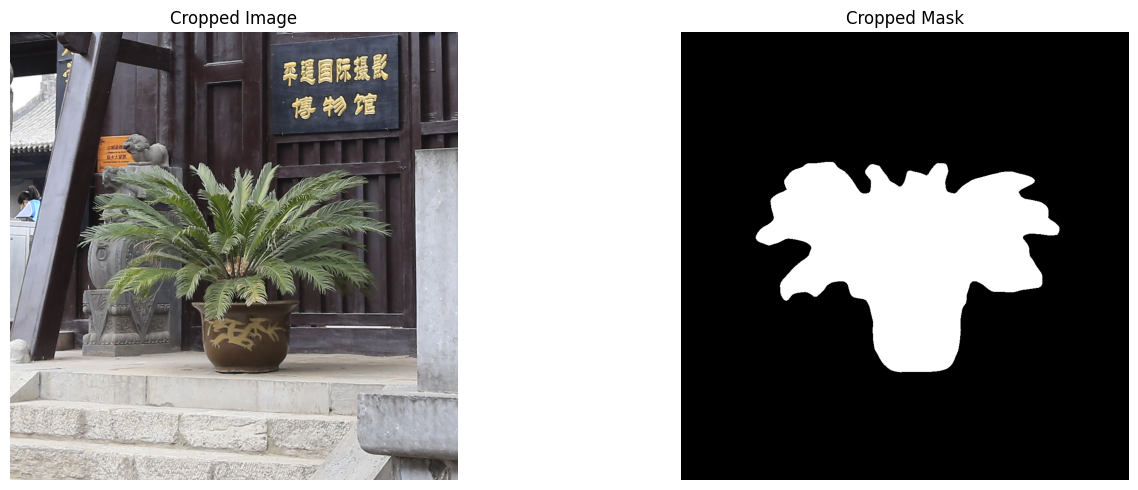

In [7]:
# @title 4. Process Results & Crop Image/Mask

# --- Output Paths ---
OUTPUT_CROPPED_IMG_PATH = "/content/gdinio_sam_cropped_input.png"
OUTPUT_CROPPED_MASK_PATH = "/content/gdinio_sam_cropped_mask.png"

# --- Initialize ---
crop_box_coords = None
crop_width, crop_height = None, None
orig_mask_path = OUTPUT_MASK_PATH # Use path defined in previous cell
processing_success = False

if pipeline_success:
    print("\n🎯 Selecting best detection...")
    best_idx = logits.argmax()
    best_mask = masks[best_idx]       # (H, W) tensor
    best_box = boxes[best_idx]        # (4,) tensor [x1, y1, x2, y2]
    best_phrase = phrases[best_idx]
    best_logit = logits[best_idx]
    print(f"Selected #{best_idx.item()} (Phrase: '{best_phrase}', Score: {best_logit:.4f})")

    print("💾 Creating and saving full-size mask...")
    mask_np = best_mask.cpu().numpy().astype(bool)
    full_mask_image_np = np.zeros((orig_height, orig_width, 3), dtype=np.uint8)
    full_mask_image_np[mask_np] = [255, 255, 255]
    full_mask_image = Image.fromarray(full_mask_image_np)
    full_mask_image.save(OUTPUT_MASK_PATH)
    print(f"Full mask saved to {OUTPUT_MASK_PATH}")
    # display_images(OUTPUT_MASK_PATH, "Generated Full-Size Mask (Best Detection)")


    print("\n✂️ Cropping image and mask around best detection...")
    x1, y1, x2, y2 = map(int, best_box.cpu().tolist())
    target_crop_size = 1024
    center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
    half_size = target_crop_size / 2

    left = int(max(0, center_x - half_size)); top = int(max(0, center_y - half_size))
    right = int(min(orig_width, left + target_crop_size)); bottom = int(min(orig_height, top + target_crop_size))
    # Boundary adjustment (optional, keep simple for now)
    # ... (could add complex adjustment logic back if needed) ...
    left,top,right,bottom = max(0,left),max(0,top),min(orig_width,right),min(orig_height,bottom)
    crop_box_coords = (left, top, right, bottom)

    cropped_img = image_pil.crop(crop_box_coords)

    cropped_mask = full_mask_image.crop(crop_box_coords)
    crop_width, crop_height = cropped_img.size

    cropped_img.save(OUTPUT_CROPPED_IMG_PATH)
    cropped_mask.save(OUTPUT_CROPPED_MASK_PATH)
    print(f"Cropped to {crop_width}x{crop_height} at {crop_box_coords}")
    print(f"💾 Cropped image and mask saved.")
    display_images([OUTPUT_CROPPED_IMG_PATH, OUTPUT_CROPPED_MASK_PATH], ["Cropped Image", "Cropped Mask"])

    processing_success = True

else:
    print("🛑 Skipping processing/cropping because prediction pipeline failed or was skipped.")


⏳ Running Stable Diffusion Inpainting via Replicate...
✅ Inpainting completed. Output URL: https://replicate.delivery/yhqm/eoejw1RGdcnmtkDWwhuzJ2auEza5EwjfJ7IIoUoH3wdz35ApA/out-0.png
--- Compositing Result ---
Resized inpainted result from (1024, 1024) back to (1024, 1024).
💾 Final composited image saved to /content/final_output_gdino_sam.png


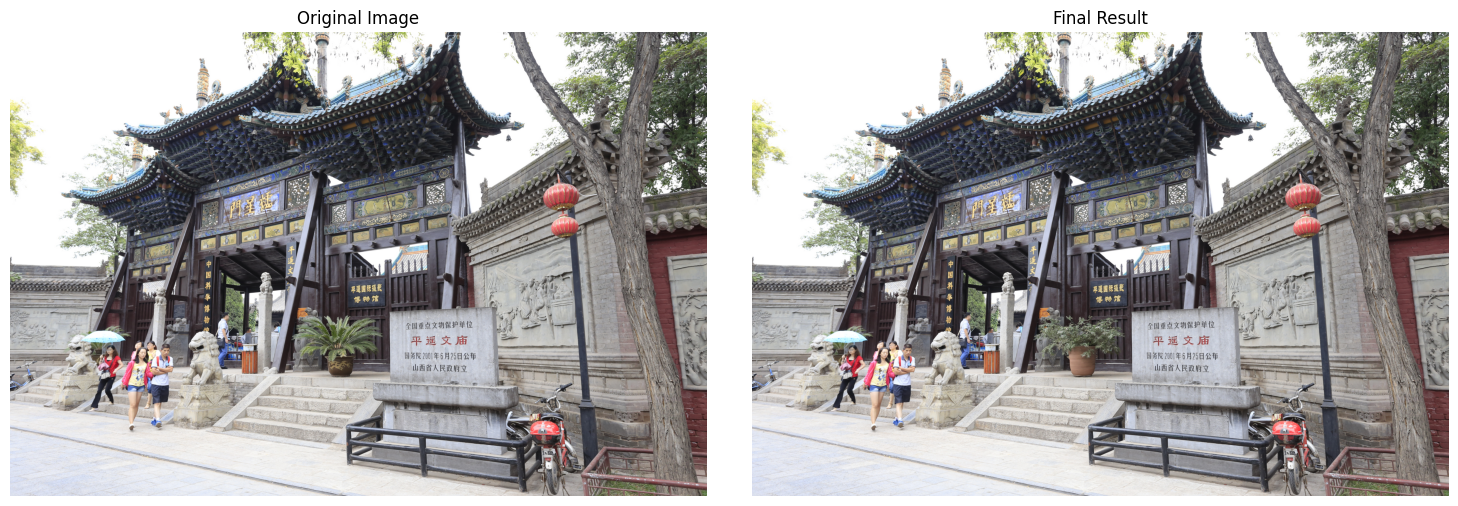

In [8]:
# @title 5. Run Replicate Inpainting and Composite Result


EDIT_PROMPT = "a beautiful terracotta pot" # Edit prompt
INPAINTED_CROP_PATH = "/content/inpainted_crop_gdino_sam.png"
FINAL_OUTPUT_PATH = "/content/final_output_gdino_sam.png"


api_width = find_largest_valid_dimension_lower_than(crop_width)
api_height = find_largest_valid_dimension_lower_than(crop_height)


print("\n⏳ Running Stable Diffusion Inpainting via Replicate...")
output = replicate.run(
    "stability-ai/stable-diffusion-inpainting:c28b92a7ecd66eee4aefcd8a94eb9e7f6c3805d5f06038165407fb5cb355ba67",
    input={
        "prompt": EDIT_PROMPT,
        "image": open(OUTPUT_CROPPED_IMG_PATH, "rb"), # Use saved crop
        "mask": open(OUTPUT_CROPPED_MASK_PATH, "rb"),  # Use saved crop mask
        "num_inference_steps": 50,
        "guidance_scale": 7.5,
        "scheduler": "DPMSolverMultistep",
        "width": api_width,       # Target dimensions for API
        "height": api_height      # Target dimensions for API
    }
)


output_url = output[0] if isinstance(output, list) else output
display_images
print(f"✅ Inpainting completed. Output URL: {output_url}")

# --- Download and Save Inpainted Crop ---
response = requests.get(output_url)
response.raise_for_status()
with open(INPAINTED_CROP_PATH, "wb") as f: f.write(response.content)
final_output_image_path = place_cropped_result_back(
    IMAGE_PATH,
    INPAINTED_CROP_PATH,
    orig_mask_path,
    FINAL_OUTPUT_PATH,
    crop_box_coords
)


display_images([IMAGE_PATH, final_output_image_path],
              ["Original Image", "Final Result"])

